# ASTR3110 Tutorial 10: CNNs
Tutorial 10 of the 'Data Science Techniques in Astrophysics' course at Macquarie University.

## Learning outcomes from this tutorial

 * Learn how to setup generators to flow data on disk to a neural network.
 * Learn how to build a convilutional neural network in the Keras framework.
 * Create diagnostic graphs and reports for a CNN to understand how well the training went.
 * Use a saved model to make a prediction for an image.
 
**Note: Using generators to constantly read data from disk does not work well with Google Drive. This is because the computer processing the data may be physically far-removed from the disk on which the data is stored. Next week we will be implementing a method to read the data fully into memory so the read time latency is removed.**

**Generators are necessary if you are processing a huge dataset that cannot fit into memory (often the case). They will work fine if you are operating on your own computer with a GPU, or are using a commercial cloud with low-latency disks.**

## Setup for Google Drive

Today we will be operating on a dataset of animal images, so start by linking to your Google drive. The dataset is available at this link: [[animals.tar.gz](https://drive.google.com/file/d/1qhm0WBjA03Uq57OsaMmurF0Qve1OmGO6/view?usp=sharing)]. Please download to your Google drive and extract to a ```DATA/``` folder that can bee seen from your notebook.

```
# Link to Google drive
from google.colab import drive
drive.mount('/content/gdrive')

# Mount your drive
cd gdrive/'My Drive'

# Unpack the dataset
!tar -xzvf animals.tar.gz
mv animals DATA/
```

In [1]:
# Import necessary modules
import os
import shutil
from keras.backend import tensorflow_backend
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.utils import plot_model
from imutils import paths

Using TensorFlow backend.
/home/cpurcell/.virtualenvs/dl_tf1.12p/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cpurcell/.virtualenvs/dl_tf1.12p/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cpurcell/.virtualenvs/dl_tf1.12p/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cp

## Accessing the data using generators

In this dataset the train-validation-test split has already been done, so we just need to create paths that point to each directory.

In [2]:
# Create the paths to the three datasets
dataDir = "DATA/animals"
trainPath = os.path.join(dataDir, "train")
validPath = os.path.join(dataDir, "valid")
testPath = os.path.join(dataDir, "test")

We are going to link several generators togerther in series to create a data-ingest pipeline. Gernerators are a way to make an object that you can iterate over to yield a new element (in this case a new batch of images). You can learn more about generators on the [official Python wiki](https://wiki.python.org/moin/Generators). 

The first generarator we create simply rescales the data from [0, 255]  to [0, 1]. The ```ImageDataGenerator``` class is a part of Keras.

In [3]:
# Generator that rescales an image that is connected to it.
# The 'Aug' in the variable name stands for 'Augment' as 
# the generator can apply other augmentations besides scaling,
# e.g., flipping, skewing, zooming. These can help the CNN
# be more accurate in the real world, but are beyond the scope
# of this tutorial.
trainAugGen = ImageDataGenerator(rescale=1./255)
validAugGen = ImageDataGenerator(rescale=1./255)
testAugGen = ImageDataGenerator(rescale=1./255)

We need to define some parameters of the training run before we connect the generators to the directory of input images.

In [4]:
# Define some parameters of the training run
# Image size in pixels
size = 150

# How many images to read at once
batchSize = 32

Now we build versions of the generator that connect to the data directories.

In [5]:
trainGen = trainAugGen.flow_from_directory(
    trainPath,
    target_size=(size, size),
    batch_size=batchSize,
    class_mode='categorical')

Found 3500 images belonging to 3 classes.


In [6]:
validGen = validAugGen.flow_from_directory(
    validPath,
    target_size=(size, size),
    batch_size=batchSize,
    class_mode='categorical')

Found 1000 images belonging to 3 classes.


In [7]:
testGen = testAugGen.flow_from_directory(
    testPath,
    target_size=(size, size),
    batch_size=1,
    class_mode='categorical',
shuffle=False)

Found 500 images belonging to 3 classes.


The generators expect a directory with images sorted into sub-directories that are named for the classes and will store the labels of each class internally.

```
animals/
├── test
│   ├── cat
│   ├── dog
│   └── panda
├── train
│   ├── cat
│   ├── dog
│   └── panda
└── valid
    ├── cat
    ├── dog
    └── panda
```
We can access them via the ```class_indices.keys()``` method.

In [8]:
# Determine the classes from the generator
classLabs = list(trainGen.class_indices.keys())
nClasses = len(classLabs)
print("[INFO] {:d} classes: {}".format(nClasses, classLabs))

[INFO] 3 classes: ['cat', 'dog', 'panda']


Count the number of images in each dataset.

In [9]:
# Count the number of train, valid and test images
# ALT: trainImgPaths = list(paths.list_images(trainPath))
trainImgPaths = trainGen.filenames
nTrainImg = len(trainImgPaths)
validImgPaths = validGen.filenames
nValidImg = len(validImgPaths)
testImgPaths = testGen.filenames
nTestImg = len(testImgPaths)
print("[INFO] {:d} training images.".format(nTrainImg))
print("[INFO] {:d} validation images.".format(nValidImg))
print("[INFO] {:d} test images.".format(nTestImg))

[INFO] 3500 training images.
[INFO] 1000 validation images.
[INFO] 500 test images.


## Building the CNN

Now it is time to build the model. Like the ANN, we create a sequential stack of layers. However, these layers accept 3D images with a width, height and depth. CNNs also tend to have repeating blocks of layers that do:

```
Convolution -> Activation - > Bining (downsize images)
```

The convolutional layer processess the image by convolving it with a number of small filters (usually 3x3). These filters start out as noise, but are changed by the training process to detect differet 'textures' in the images. 

The binning layer we use here is called ```MaxPooling``` and shrinks the resolution of the output by 1/2 (see [here](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling)). So as the image passes through the network it is reduced in size and the relative scale of the filters changes. For a quick explanation of how a CNN works see [here](https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac), [here](https://www.cs.ryerson.ca/~aharley/vis/conv/) or [here](https://arxiv.org/abs/1511.08458). For a free detailed course with deep mathematical background, see [http://cs231n.stanford.edu/](http://cs231n.stanford.edu/).

Let's define simple network. The CNN accepts an array of 3D images (compare this to the ANN, which accepts an array of flattened 1D vectors).

In [10]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

# Initialize the model and channel order
model = Sequential()
inputShape = (size, size, 3)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (3, size, size)
    chanDim = 1

# First CONV(32) => RELU => POOL(2) layer set
model.add(Conv2D(32, (3, 3), input_shape=inputShape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second CONV(32) => RELU => POOL(2) layer set
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third CONV(64) => RELU => POOL(2) layer set
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# FC(64) => RELU => DROP(0.5)
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Softmax classifier
model.add(Dense(nClasses))
model.add(Activation('softmax'))

Now we choose an optimiser (default to stochastic gradient descent) and compile the model.

In [11]:
# Set the learning rate and compile the model.
# The loss function and accuracy metric are standard for
# classification problems with n>2.
opt = SGD(lr=0.001)    
model.compile(loss="categorical_crossentropy", optimizer=opt,
                  metrics=["accuracy"])

## Saving the best model for later use

Before we start training, we want to setup a method to save the best model in a file on disk. This can be used later in inference mode to make predictions on new data. Here we are going to define a 'callback' - a function that is called at the end of each training epoch and saves acopy of the model and weights (filters) to disk. Keras comes with some useful pre-defined callbacks.

In [12]:
# First make the output directory 
outDir = 'OUT'
if not os.path.exists(outDir):
        os.makedirs(outDir)
        
# Set the save file path
modelPath = os.path.join(outDir, "model_best.hdf5")

In [13]:
from keras.callbacks import ModelCheckpoint

# ModelCheckpoint creates a callback function that writes
# a model file to disk only if it is better than the
# previous one. We will define the relative model goodness
# by comparing loss values
checkpoint = ModelCheckpoint(modelPath,
                            monitor="val_loss",
                            save_best_only=True,
                            save_weights_only=False,
                            verbose=0)

## Training the classifier

Now we set the final training parameters and train the CNN classifier

In [14]:
# Set the batch: how many images to process at one time.
# This is a memory limit that is dependent on image size
# and dataset size.
batchSize = 32

# Guess the number of epochs
nEpochs = 50

# Train the model, storing the history in H
H = model.fit_generator(
    trainGen,
    steps_per_epoch=nTrainImg // batchSize,
    validation_data=validGen,
    validation_steps=nValidImg // batchSize,
    epochs=nEpochs,
    callbacks=[checkpoint],
    verbose=1)

Epoch 1/50
109/109 [==============================] - 12s 109ms/step - loss: 1.0840 - acc: 0.4016 - val_loss: 1.0718 - val_acc: 0.4022
Epoch 2/50
109/109 [==============================] - 12s 107ms/step - loss: 1.0639 - acc: 0.4129 - val_loss: 1.0574 - val_acc: 0.4101
Epoch 3/50
109/109 [==============================] - 11s 105ms/step - loss: 1.0558 - acc: 0.4096 - val_loss: 1.0536 - val_acc: 0.4060
Epoch 4/50
109/109 [==============================] - 12s 106ms/step - loss: 1.0507 - acc: 0.4050 - val_loss: 1.0393 - val_acc: 0.4163
Epoch 5/50
109/109 [==============================] - 11s 104ms/step - loss: 1.0381 - acc: 0.4040 - val_loss: 1.0381 - val_acc: 0.3936
Epoch 6/50
109/109 [==============================] - 11s 101ms/step - loss: 1.0312 - acc: 0.4172 - val_loss: 1.0232 - val_acc: 0.4143
Epoch 7/50
109/109 [==============================] - 11s 100ms/step - loss: 1.0168 - acc: 0.4370 - val_loss: 1.0139 - val_acc: 0.4236
Epoch 8/50
109/109 [==============================] - 1

Finally, we can save the text label in a JSON formatted text file for later use.

In [15]:
import json

# Extract the labels as a dictionary
labelDict = {v: k for k, v in trainGen.class_indices.items()}

# Save to a file
labelPath = os.path.join(outDir, "labels.json")
with open(labelPath, "w") as FH:
        FH.write(json.dumps(labelDict))

## Evaluating the classifier and training session

Let's start by visualising the traiing curves. We will make a function to do this and format it nicely.

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set larger font sizes
mpl.rcParams["font.size"] = 12.0

def plot_train_curves(H):

    # Create the figure
    fig = plt.figure(figsize=(14., 6.))
    
    # Sub-plot for the loss curves
    ax1 = fig.add_subplot(1,2,1)    
    epoch = range(1, len(H["loss"])+1)
    ax1.step(epoch, H["loss"], where="mid", label="Train Loss")
    ax1.step(epoch, H["val_loss"], where="mid", label="Valid Loss")
    ax1.legend(loc="best", shadow=False, fontsize="medium")
    ax1.set_title("Model Loss [Epoch {:d}]".format(epoch[-1]))
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epoch")
    
    # Sub-plot for the accuracy curves
    ax2 = fig.add_subplot(1,2,2)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.step(epoch, H["acc"], where="mid", label="Train Accuracy")
    ax2.step(epoch, H["val_acc"], where="mid", label="Valid Accuracy")
    ax2.legend(loc="lower right", shadow=False, fontsize="medium")
    ax2.set_title("Model Accuracy [Epoch {:d}]".format(epoch[-1]))
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Epoch")

    # Apply nice formatting
    ax1.tick_params(pad=7)
    for line in ax1.get_xticklines() + ax1.get_yticklines():
        line.set_markeredgewidth(1)
        ax2.tick_params(pad=7)
    for line in ax2.get_xticklines() + ax2.get_yticklines():
        line.set_markeredgewidth(1)
        plt.tight_layout()

Now use the function to plot the training curves.

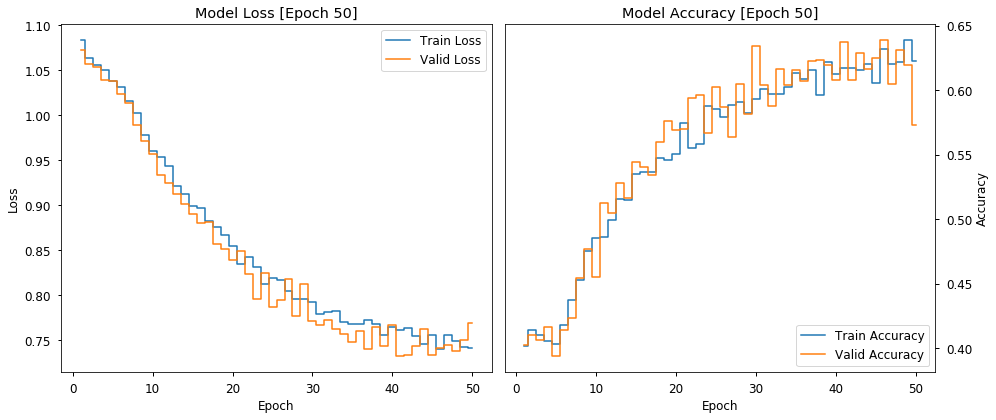

In [17]:
# Plot the training curves
plot_train_curves(H.history)

You can see here that after 50 epochs the loss is still trending down and the accuracy is still climbing for both curves. We could probably train for more time and reach greater accuracy. You can see also that the validation accuracy curve is tracking the training curve - this means we are not overfitting. A flattened validation accuracy curve and a climbing training curve (i.e., diverging) is a sign of overfitting.

Now evaluate the model's performance in mumbers.

In [18]:
from sklearn.metrics import classification_report

# Predist labels for the test set
predictions = model.predict_generator(
    testGen,
    steps=nTestImg,
    max_queue_size=2)

nPred = predictions.shape[0]

# Each class is assigned a probabalilty of being correct
# so get the index of the highest probability 
yPred = predictions.argmax(axis=1)

# Compare the truth with predictions and print a report
yTrue = testGen.classes
report = classification_report(yTrue,
                               yPred,
                               target_names=classLabs)
print(report)

              precision    recall  f1-score   support

         cat       0.69      0.34      0.45       200
         dog       0.51      0.69      0.58       200
       panda       0.62      0.83      0.71       100

    accuracy                           0.57       500
   macro avg       0.61      0.62      0.58       500
weighted avg       0.60      0.57      0.56       500



An alternative way to look visualise predictions is to make a confusion matrix. This has true labels on one axis and predicted labels on another. A perfect classifier has only entries in the diagonal meaning that all images were correctly labelled.

In [19]:
from sklearn.metrics import confusion_matrix
cmatrix = confusion_matrix(yTrue, yPred)
print(cmatrix)

[[ 67 116  17]
 [ 29 137  34]
 [  1  16  83]]


# Using the saved model to make predictions

The best-fitting model has been saved to ```OUT/model_best.hdf5```. We can re-load that file and use it to make a prediction for a new image.

In [20]:
!ls OUT

labels.json  model_best.hdf5


In [21]:
# Import some helper functions that are part of keras
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

In [22]:
# Load the model from the HDF5 file
modelFile = "OUT/model_best.hdf5"
model = load_model(modelFile)

# Load the labels from the JSON file
labelFile = "OUT/labels.json"
with open(labelFile, "r")  as FH:
    labelDict = json.load(FH)
    
# JSON stores numbers as text, so convert back to integers
labelDict = {int(k): v for k, v in labelDict.items()}

Now we need to load and pre-process the image. Note that the exact same steps need to be performed on the input image as we did for our training data *except any additional augmentations like warping or flipping* (which were not done in this tutorial anyway).

In [23]:
import numpy as np

# Choose an image file to predict a label for
imageFile = "DATA/animals/test/cat/cat.1903.jpg"

# Load the image into an array and resize
image = load_img(imageFile, target_size=(150, 150))

# Convert to the format Keras wants
image = img_to_array(image)

# The predictor is expecting a 4D array: multiple images
# in a batch (nImg, x, y, channels). We need to reshape
# our single image into a 4D array with a dummy dimension.
image = np.expand_dims(image, axis=0)

# Fnally scale from [0, 255] to [0, 1]
image /= 255

In [24]:
# Process the image through the network
probs = model.predict(image)
print(probs)

# Parse the highest probability label
idx = np.argmax(probs)
predLab = labelDict[idx]
predProb = probs[0, idx]
print("\nPrecicted label is {} with probability of {:.2f}".format(predLab, predProb))

[[0.54566276 0.43768132 0.01665596]]

Precicted label is cat with probability of 0.55


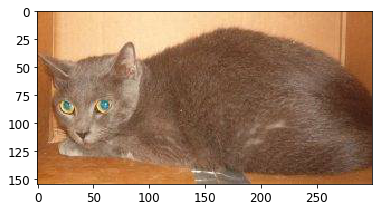

In [25]:
# Lets look at the image
plt.imshow(load_img(imageFile))